# 1.Imports & environment

In [1]:
import math
import torch
from torch.optim.optimizer import Optimizer
import numpy as np


class NosAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8,
                 weight_decay=0, gamma=0, lr_decay=False):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        if not 0.0 <= gamma:
            raise ValueError("Invalid gamma value: {}".format(gamma))
        defaults = dict(lr=lr, betas=betas, eps=eps,
                        weight_decay=weight_decay, gamma=gamma, lr_decay=lr_decay)
        super(NosAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(NosAdam, self).__setstate__(state)
        for group in self.param_groups:
            group.setdefault('lr_decay', False)

    def step(self, closure=None):
        """Performs a single optimization step.

        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')
                # amsgrad = group['amsgrad']

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg'] = torch.zeros_like(p.data)
                    # Exponential moving average of squared gradient values
                    state['exp_avg_sq'] = torch.zeros_like(p.data)

                    state['B_old'] = 0
                    state['B_new'] = 1
                    # if amsgrad:
                        # Maintains max of all exp. moving avg. of sq. grad. values
                        # state['max_exp_avg_sq'] = torch.zeros_like(p.data)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                # if amsgrad:
                #     max_exp_avg_sq = state['max_exp_avg_sq']
                beta1, beta2 = group['betas']
                beta2 = state['B_old']/state['B_new']
                gamma = group['gamma']
                # pnorm = group['pnorm']
                lr_decay = group['lr_decay']

                state['step'] += 1

                step = state['step']
                state['B_old'] += math.pow(step, -gamma)
                state['B_new'] += math.pow(step+1, -gamma)


                if group['weight_decay'] != 0:
                    grad = grad.add(group['weight_decay'], p.data)

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(1 - beta1, grad)
                # if pnorm == 2:
                #     exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                # elif pnorm ==3:
                #     # exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, np.multiply(grad, grad))
                #     exp_avg_sq = beta2*exp_avg_sq + (1 - beta2) * np.power(grad, 3)
                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)

                # if amsgrad:
                #     # Maintains the maximum of all 2nd moment running avg. till now
                #     torch.max(max_exp_avg_sq, exp_avg_sq, out=max_exp_avg_sq)
                #     # Use the max. for normalizing running avg. of gradient
                #     denom = max_exp_avg_sq.sqrt().add_(group['eps'])
                # else:
                # if pnorm ==2:
                #     denom = exp_avg_sq.sqrt().add_(group['eps'])
                # elif pnorm==3: # pnorm = 3
                #     denom = np.cbrt(exp_avg_sq) + group['eps']

                denom = exp_avg_sq.sqrt().add_(group['eps'])
                bias_correction1 = 1 - beta1 ** state['step']
                # AdaStab no longer needs bias correction for v_t
                # bias_correction2 = 1 - beta2 ** state['step']
                step_size = group['lr'] / bias_correction1
                if lr_decay:
                    step_size = step_size/math.sqrt(state['step'])


                p.data.addcdiv_(-step_size, exp_avg, denom)

        return loss

    def denominator(self):
        denom = np.array([0])
        denom_sum = 0
        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data
                if grad.is_sparse:
                    raise RuntimeError('Adam does not support sparse gradients, please consider SparseAdam instead')

                state = self.state[p]
                exp_avg_sq = state["exp_avg_sq"]

                exp_avg_sq = exp_avg_sq.numpy()
                exp_avg_sq = np.reshape(exp_avg_sq, -1)
                denom = np.concatenate((denom, exp_avg_sq))
                denom_sum += torch.sum(exp_avg_sq)
        return denom, denom_sum

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import os
import gzip
import numpy as np
import sys
# from NosAdam import NosAdam
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" #magic line to deal with my versions of libraries

# Setup predictable randomization
seed = 10
np.random.seed(seed)

# Setup CUda
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 2. Loading and preparation of data
As a basis for comparison we will be using the MNIST dataset. If we manage to do all the work we want, we will then use other datasets for comparison.

### 2.1. Definition of methods to extract data and labels

In [3]:
def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

### 2.2. Load data

In [4]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000
data_folder = 'mnist_data'

train_images_path = os.path.join(data_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

### 2.3. Convert data from numpy arrays to torch tensors

In [5]:
features_train=torch.from_numpy(train_images).to(device)
features_test=torch.from_numpy(test_images).to(device)
print('Training features:', features_train.shape, '\n'
'Testing features:', features_test.shape)

labels_train=torch.from_numpy(train_labels).to(device)
labels_test=torch.from_numpy(test_labels).to(device)
print('Training labels:', labels_train.shape, '\n'
'Testing labels:', labels_test.shape)

Training features: torch.Size([60000, 28, 28]) 
Testing features: torch.Size([10000, 28, 28])
Training labels: torch.Size([60000]) 
Testing labels: torch.Size([10000])


### 2.4. Normalize data

In [6]:
mean, std = features_train.float().mean(), features_train.float().std()

features_train = features_train.float().sub_(mean).div_(std)
features_test = features_test.float().sub_(mean).div_(std)

In [7]:
#reshape to make the 1st channel be batch size

features_train = features_train.reshape(-1, 1, 28, 28)
features_test = features_test.reshape(-1, 1, 28, 28)

# 3. Setting up networks and evaluation methods

### 3.1. Multilayer perceptron (MLP)

In [ ]:
class MLP(nn.Module):
    
    def __init__(self, hidden_size_1=512, hidden_size_2=100, hidden_size_3=10):
        super(MLP, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, hidden_size_1),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size_1, hidden_size_2),
            nn.ReLU(inplace=True),
            nn.Linear(hidden_size_2, hidden_size_3))
    
    # forward pass
    def forward(self, x):
        return self.layers(x)

mlp = MLP()

###3.2. Convolutional Neural Network (CNN)

In [8]:
from numpy.ma.core import reshape
class CNN(nn.Module):
   def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, kernel_size=5, stride=1, padding='same')
        self.conv2 = torch.nn.Conv2d(32, 64, kernel_size=5, stride=1, padding='same')
        self.fc1 = nn.Linear(64*7*7, 1024)
        self.fc2 = nn.Linear(1024, 10)

   def forward(self, input:torch.Tensor) -> torch.Tensor:
        pool1 = torch.max_pool2d(F.relu(self.conv1(input)), kernel_size=2, stride=2)
        pool2 = torch.max_pool2d(F.relu(self.conv2(pool1)), kernel_size=2, stride=2)
        res = pool2.reshape(-1, 64*7*7)
        hidden = F.relu(self.fc1(res))
        output = self.fc2(hidden)

        return output


### 3.3. Implementation of method for training

In [9]:
def run_nn(x_train, y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch):
    # loss_all_train, loss_all_test = [], []
    loss_train_ret = 0
    loss_test_ret = 0
    loss_train = 0
    # epochs_all = torch.arange(1, num_epoch+num_epoch/10, num_epoch/10)
    # epochs_all[-1] = num_epoch - 1
            
    for epoch in range(num_epoch):
        for b in range(0, x_train.size(0), size_minibatch):
            # y = model(x_train.narrow(0, b, size_minibatch))
            # loss_train = criterion(y, y_train.narrow(0, b, size_minibatch))
            y = model(x_train[b:b+size_minibatch])
            loss_train = criterion(y, y_train[b:b+size_minibatch])
        
            optimizer.zero_grad()
            loss_train.backward()
            optimizer.step()

        if epoch == num_epoch - 1:
            # loss_train = loss_train.detach().numpy()
            # loss_all_train.append(loss_train)

            y_test_obt = model(x_test)
            loss_test = criterion(y_test_obt, y_test)
            # loss_test = loss_test.detach().numpy()
            # loss_all_test.append(loss_test)
            
            loss_train_ret = loss_train
            loss_test_ret = loss_test
            
            print('Final, Train Loss: %.4f, Test Loss: %.4f' %(loss_train, loss_test))

    return loss_train_ret, loss_test_ret

# 4. Metrics of our tuning protocol
At this stage, we want to select the hyperparameter search space for each optimizer. This way, we can first tune the hyperparameters of each optimizer separately and then select the trial that achieved lowest final validation error.
We then comapre the optimizers' performance by looking at the validation and test errors as suggested in the paper "On empirical comparisons of optimizers for deep learning".

We will also look at the training speed (number of training steps required) to reach a traget validation error.

Everything is tuned on a log scale.

No L_2 regularization or weight decay is used.

### 4.1. Tuning protocol using bootstrap
To estimate means and uncertainties of our tuning protocol we will use bootstrapping starting from an initial search space suggested by the paper "On Empirical Comparisons of Optimizers for Deep Learning".
We run N trials by randomly picking values in the search space of the algorithm at every trial.
Then we sample these trials with replacement and compute our statistic on the first K trials of this sample. We repeat this process 100 times and compute the 5th percentile and 95th percentile of the bootstrap distribution.

This allows us to plot the error bars to show the results.

### 4.2. Tuning NosAdam for the MLP on MNIST
The hyperparameters we are tuning are alpha_0/epsilon, 1 - beta_1, 1 - beta_2, epsilon.
The initial search spaces are suggested based on the experience of the writers of the same paper, "On empirical comparisons of optimizers for deep learning".
N is also suggested to be 500 and K to be 100.

##### Set up model for training

In [ ]:
# Model fixed parameters
model = MLP()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device) # good loss function for classification tasks
num_epoch = 50
size_minibatch = 128

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

##### Tune to find best parameter
We perform trials until we have K of them, then we pick the best based on our statistic of interest

#### 4.2.1. Initial search for best hyperparameters for **NosAdam** optimizer on **MLP**. K= 100. 
Interrupted because of nan loss.

##### Set up parameters and search space for the initial trial

In [ ]:
N = 200
K = 100 # Number of trials being kept for the statistic

# Initial search spaces for parameters
alpha_0 = np.linspace(10**(-2), 10**(4), N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-10), 10**(10), N)

# TODO: tune number of decay steps between 0.5 and 1 times the number of training steps
# TODO : tune learning rate decay factor within 10**-3, 10**-2, 10**-1

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)

for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=MLP()
    model=model.to(device)
    optimizer = NosAdam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

c:\Users\Claudia Naumova\Opt_ML\OptML_project\NosAdam.py:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: 0.5216, Test Loss: 0.4796
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan


KeyboardInterrupt: 

#### 4.2.2. Final search for best hyperparameters for **NosAdam** optimizer on **MLP**. K = 50

##### Set up parameters and search space for the final trial

In [ ]:
N = 200
K = 50 # Number of trials being kept for the statistic

# Final search spaces for parameters
alpha_0 = np.linspace(10**(-1), 10, N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-6), 10**(-2), N)

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)


for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model = MLP()
    model = model.to(device)
    optimizer = NosAdam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

c:\Users\Claudia Naumova\Opt_ML\OptML_project\NosAdam.py:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ..\torch\csrc\utils\python_arg_parser.cpp:1050.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)


Final, Train Loss: 0.0001, Test Loss: 0.0810
Final, Train Loss: 1.8264, Test Loss: 1.8137
Final, Train Loss: 0.2071, Test Loss: 0.1658
Final, Train Loss: 0.0000, Test Loss: 0.0994
Final, Train Loss: 2.3058, Test Loss: 2.3015
Final, Train Loss: 0.0387, Test Loss: 0.2560
Final, Train Loss: 0.2790, Test Loss: 0.4581
Final, Train Loss: 1.7682, Test Loss: 1.7026
Final, Train Loss: 2.3060, Test Loss: 2.3016
Final, Train Loss: 0.0476, Test Loss: 0.2908
Final, Train Loss: 0.1852, Test Loss: 0.3003
Final, Train Loss: 0.0000, Test Loss: 0.1531
Final, Train Loss: 2.3071, Test Loss: 2.3018
Final, Train Loss: 0.0236, Test Loss: 0.3225
Final, Train Loss: 0.0000, Test Loss: 0.1110
Final, Train Loss: 2.3067, Test Loss: 2.3018
Final, Train Loss: 0.0000, Test Loss: 0.1217
Final, Train Loss: 2.3075, Test Loss: 2.3027
Final, Train Loss: 2.3052, Test Loss: 2.3016
Final, Train Loss: 0.0028, Test Loss: 0.2247
Final, Train Loss: 1.8098, Test Loss: 1.8529
Final, Train Loss: 0.0000, Test Loss: 0.0846
Final, Tra

In [ ]:
# Print best parameters

print('Beta 1: %.2f' % lowest_test_error[0])
print('Beta 2: %.2f' % lowest_test_error[1])
print('Epsilon: %.2e' % lowest_test_error[2])
print('Learning rate: %.6f' % lowest_test_error[3])
print('Train error: %.6f' % lowest_test_error[4])
print('Test error: %.4f' % lowest_test_error[5])

Beta 1: 0.25
Beta 2: 0.84
Epsilon: 1.52e-04
Learning rate: 0.000068
Train error: 0.006410
Test error: 0.0652


##### 4.2.3. Estimating trial outcomes via bootstrap
At this stage we want to estimate means and uncertainties of our tuning protocol

###### Run N trials

In [ ]:
# We first run and store N trials
N=200
N_trials = []


for _ in range(N):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model = MLP()
    model = model.to(device)
    optimizer = NosAdam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Store parameters, train and test error
    N_trials.append([beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)


Final, Train Loss: 1.8994, Test Loss: 1.7757
Final, Train Loss: 0.2170, Test Loss: 0.1633
Final, Train Loss: 0.0000, Test Loss: 0.0932
Final, Train Loss: 2.3058, Test Loss: 2.3016
Final, Train Loss: 0.0212, Test Loss: 0.2788
Final, Train Loss: 1.6695, Test Loss: 1.4105
Final, Train Loss: 0.9822, Test Loss: 0.9878
Final, Train Loss: 1.6502, Test Loss: 1.6149
Final, Train Loss: 0.5107, Test Loss: 0.3931
Final, Train Loss: 0.0437, Test Loss: 0.2538
Final, Train Loss: 0.0001, Test Loss: 0.1491
Final, Train Loss: 2.0552, Test Loss: 1.9812
Final, Train Loss: 0.0766, Test Loss: 0.2807
Final, Train Loss: 0.0000, Test Loss: 0.1039
Final, Train Loss: 2.2462, Test Loss: 2.0222
Final, Train Loss: 0.0001, Test Loss: 0.1657
Final, Train Loss: 2.3075, Test Loss: 2.3027
Final, Train Loss: 2.3052, Test Loss: 2.3017
Final, Train Loss: 0.0501, Test Loss: 0.3256
Final, Train Loss: 2.3072, Test Loss: 2.3017
Final, Train Loss: 0.0000, Test Loss: 0.0926
Final, Train Loss: 2.3053, Test Loss: 2.3015
Final, Tra

In [ ]:
import pickle
with open("N_trials_nosadam_mlp.pth", "wb") as fp:
  pickle.dump(N_trials, fp)

###### Perform bootstrapping

In [ ]:
means_train = []
means_test  = []
# N_trials = N_trials.to('cpu')
# Do the following 100 times :
for _ in range(100):
    # Resample N samples from the N-trials with replacement
    N_sampled_indices = np.random.choice(list(range(len(N_trials))), N) # choose random indices in the list of N trials
    
    # Recover the lists associated to the indices and keep only intersting information, i.e. test and train errors
    N_sampled_train_error = np.array([N_trials[i][4].cpu().detach().numpy() for i in N_sampled_indices])
    N_sampled_test_error = np.array([N_trials[i][5].cpu().detach().numpy() for i in N_sampled_indices])
    
    # Compute statistic on the first K trials of the resampled dataset
    means_train.append(N_sampled_train_error[:K].mean())
    means_test.append(N_sampled_test_error[:K].mean())
    
# 5th percentile, 95 percentile of bootrap distribution
fifth_percentile_train = np.percentile(means_train, 5)
fifth_percentile_test = np.percentile(means_test, 5)

ninety_fifth_percentile_train = np.percentile(means_train, 95)
ninety_fifth_percentile_test = np.percentile(means_test, 95)

# For plotting purposes only
mean_all_train = np.array(means_train).mean()
mean_all_test = np.array(means_test).mean()

###### Generate plots for mean error bars for training

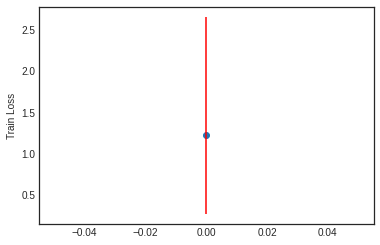

In [ ]:
# Train plot, each index in x will be a different optimizer and y its values
plt.style.use('seaborn-white')
plt.scatter(x=[0], y=[mean_all_train])
plt.errorbar(x=[0], y=[mean_all_train], yerr=[[fifth_percentile_train],[ninety_fifth_percentile_train]], ecolor='red', color='black')
plt.ylabel('Train Loss')
plt.savefig('Train_nosadam_mlp.pdf')
plt.show()

###### Generate plots for mean error bars for testing

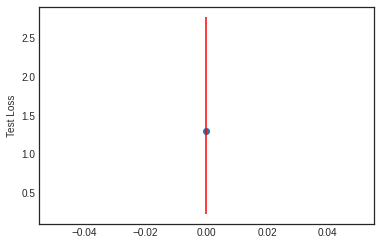

In [ ]:
# Train plot, each index in x will be a different optimizer and y its values
plt.style.use('seaborn-white')
plt.scatter(x=[0], y=[mean_all_test])
plt.errorbar(x=[0], y=[mean_all_test], yerr=[[fifth_percentile_test],[ninety_fifth_percentile_test]], ecolor='red', color='black')
plt.ylabel('Test Loss')
plt.savefig('Test_nosadam_mlp.pdf')
plt.show()

### 4.3. Tuning Adam for the CNN on MNIST

##### Set up model for training

In [10]:
# Model fixed parameters
model = CNN()
model = model.to(device)
criterion = nn.CrossEntropyLoss().to(device) # good loss function for classification tasks
num_epoch = 50
size_minibatch = 128

x_train = features_train
y_train = labels_train
x_test = features_test
y_test = labels_test

##### Tune to find best parameter
We perform trials until we have K of them, then we pick the best based on our statistic of interest

#### 4.3.1. Initial search for best hyperparameters for **Adam** optimizer on **CNN**. K= 100. 
Interrupted because of nan loss.

##### Set up parameters and search space for the initial trial

In [12]:
N = 200
K = 100 # Number of trials being kept for the statistic

# Initial search spaces for parameters
alpha_0 = np.linspace(10**(-2), 10**(4), N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-10), 10**(10), N)

# TODO: tune number of decay steps between 0.5 and 1 times the number of training steps
# TODO : tune learning rate decay factor within 10**-3, 10**-2, 10**-1

Perform search

In [13]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)

for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=CNN()
    model=model.to(device)
    optimizer = NosAdam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    # train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch)
    
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)


Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: 0.2715, Test Loss: 0.1980
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: 1954.3563, Test Loss: 2359.0366
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: nan, Test Loss: nan
Final, Train Loss: 1335.0944, Test Loss: 865.0282
Final, Train Loss: nan, Test Loss: nan


KeyboardInterrupt: ignored

#### 4.3.2. Final search for best hyperparameters for **Adam** optimizer on **CNN**. K = 50

##### Set up parameters and search space for the final trial

In [11]:
N = 200
K = 50 # Number of trials being kept for the statistic

# Final search spaces for parameters
alpha_0 = np.linspace(10**(-1), 10, N)
beta_1 = np.linspace(10**(-3), 1, N)
beta_2 = np.linspace(10**(-4), 1, N)
eps = np.linspace(10**(-6), 10**(-2), N)

Perform search

In [ ]:
nb_hyperamaters_to_tune = 4
nb_exported_statistics  = 2

lowest_test_error = [sys.maxsize] * (nb_hyperamaters_to_tune + nb_exported_statistics)


for _ in range(K):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    model=CNN()
    model=model.to(device)
    optimizer = NosAdam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = run_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Concatenate hyperparameters with results
    vector = [beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error]
    
    # Check wether we have the smallest test error and store parameters in case we find it
    if test_error < lowest_test_error[len(lowest_test_error) - 1]:
        lowest_test_error = vector

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:86: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at  ../torch/csrc/utils/python_arg_parser.cpp:1055.)


Final, Train Loss: 0.0000, Test Loss: 0.0315
Final, Train Loss: 2.3064, Test Loss: 2.3018
Final, Train Loss: 0.1972, Test Loss: 0.0344
Final, Train Loss: 0.0000, Test Loss: 0.0566
Final, Train Loss: 2.3057, Test Loss: 2.3015
Final, Train Loss: 2.3049, Test Loss: 2.3015
Final, Train Loss: 2.3053, Test Loss: 2.3015
Final, Train Loss: 2.3062, Test Loss: 2.3015
Final, Train Loss: 2.3060, Test Loss: 2.3016
Final, Train Loss: 2.3049, Test Loss: 2.3015
Final, Train Loss: 0.0000, Test Loss: 0.2152
Final, Train Loss: 0.0025, Test Loss: 0.1179
Final, Train Loss: 2.3072, Test Loss: 2.3018
Final, Train Loss: 0.0046, Test Loss: 0.1936
Final, Train Loss: 0.0000, Test Loss: 0.0393
Final, Train Loss: 2.3069, Test Loss: 2.3018
Final, Train Loss: 0.0000, Test Loss: 0.0466
Final, Train Loss: 2.3057, Test Loss: 2.3021
Final, Train Loss: 2.3053, Test Loss: 2.3016
Final, Train Loss: 0.8203, Test Loss: 0.3002
Final, Train Loss: 2.3070, Test Loss: 2.3019
Final, Train Loss: 0.0000, Test Loss: 0.0326
Final, Tra

In [ ]:
# Print best parameters

print('Beta 1: %.2f' % lowest_test_error[0])
print('Beta 2: %.2f' % lowest_test_error[1])
print('Epsilon: %.2e' % lowest_test_error[2])
print('Learning rate: %.2f' % lowest_test_error[3])
print('Train error: %.6f' % lowest_test_error[4])
print('Test error: %.4f' % lowest_test_error[5])

##### 4.3.3. Estimating trial outcomes via bootstrap
At this stage we want to estimate means and uncertainties of our tuning protocol

###### Run N trials

In [ ]:
# We first run and store N trials
N=200
N_trials = []
model = CNN()
model = model.to(device)

for _ in range(N):
    # Pick random values from the intervals given for the different parameters
    alpha_0_pick  = float(np.random.choice(alpha_0, 1)) # np.random.choice samples uniformely with replacement
    beta_1_pick   = float(-np.random.choice(beta_1, 1) + 1)
    beta_2_pick   = float(-np.random.choice(beta_2, 1) + 1)
    eps_pick      = float(np.random.choice(eps, 1))
    learning_rate = alpha_0_pick * eps_pick
    
    # Build optimizer from parameters
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, betas=(beta_1_pick, beta_2_pick), eps=eps_pick)
    
    # Run
    train_error, test_error = mlp_nn(x_train,y_train, x_test, y_test, model, optimizer, criterion, num_epoch, size_minibatch)
    
    # Store parameters, train and test error
    N_trials.append([beta_1_pick, beta_2_pick, eps_pick, learning_rate, train_error, test_error])

###### Perform bootstrapping

In [ ]:
means_train = []
means_test  = []
# Do the following 100 times :
for _ in range(100):
    # Resample N samples from the N-trials with replacement
    N_sampled_indices = np.random.choice(list(range(len(N_trials))), N) # choose random indices in the list of N trials
    
    # Recover the lists associated to the indices and keep only intersting information, i.e. test and train errors
    N_sampled_train_error = np.array([N_trials[i][4] for i in N_sampled_indices])
    N_sampled_test_error = np.array([N_trials[i][5] for i in N_sampled_indices])
    
    # Compute statistic on the first K trials of the resampled dataset
    means_train.append(N_sampled_train_error[:K].mean())
    means_test.append(N_sampled_test_error[:K].mean())
    
# 5th percentile, 95 percentile of bootrap distribution
fifth_percentile_train = np.percentile(means_train, 5)
fifth_percentile_test = np.percentile(means_test, 5)

ninety_fifth_percentile_train = np.percentile(means_train, 95)
ninety_fifth_percentile_test = np.percentile(means_test, 95)

# For plotting purposes only
mean_all_train = np.array(means_train).mean()
mean_all_test = np.array(means_test).mean()

###### Generate plots for mean error bars for training

In [ ]:
# Train plot, each index in x will be a different optimizer and y its values
plt.scatter(x=[0], y=[mean_all_train])
plt.errorbar(x=[0], y=[mean_all_train], yerr=[[fifth_percentile_train],[ninety_fifth_percentile_train]], ecolor='red', color='black')
plt.show()

###### Generate plots for mean error bars for testing

In [ ]:
# Train plot, each index in x will be a different optimizer and y its values
plt.scatter(x=[0], y=[mean_all_test])
plt.errorbar(x=[0], y=[mean_all_test], yerr=[[fifth_percentile_test],[ninety_fifth_percentile_test]], ecolor='red', color='black')
plt.show()